<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/Image_Inpaint_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Loading Dataset


In [1]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.8 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
import pandas as pd

# Load the CelebA-HQ dataset
ds = load_dataset("saitsharipov/CelebA-HQ")

# Check if dataset loaded correctly
if ds is None:
    raise ValueError("Dataset not loaded correctly")


(…)-00002-of-00003-4f9459a488896f53.parquet:  68%|######7   | 315M/465M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/202599 [00:00<?, ? examples/s]

In [4]:
from datasets import load_dataset
import pandas as pd

# Load the CelebA-HQ dataset
ds = load_dataset("saitsharipov/CelebA-HQ")

# Print basic information about the dataset
print("Dataset structure:")
print(ds)

# Inspect the first few items in the training set
print("\nFirst few items in the training set:")
for i, item in enumerate(ds['train'].take(5)):
    print(f"Item {i}:")
    for key, value in item.items():
        if key == 'image':
            print(f"  {key}: <PIL.Image.Image image mode={value.mode} size={value.size}>")
        else:
            print(f"  {key}: {value}")
    print()

# Get all column names (attributes)
column_names = list(ds['train'].features.keys())
print("\nColumn names:")
print(column_names)

# Convert a small subset of the dataset to a pandas DataFrame for easier inspection
df = pd.DataFrame(ds['train'].select(range(100)))
print("\nDataFrame head:")
print(df.head())

# Print data types of columns
print("\nColumn data types:")
print(df.dtypes)

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 202599
    })
})

First few items in the training set:
Item 0:
  image: <PIL.Image.Image image mode=RGB size=(178, 218)>

Item 1:
  image: <PIL.Image.Image image mode=RGB size=(178, 218)>

Item 2:
  image: <PIL.Image.Image image mode=RGB size=(178, 218)>

Item 3:
  image: <PIL.Image.Image image mode=RGB size=(178, 218)>

Item 4:
  image: <PIL.Image.Image image mode=RGB size=(178, 218)>


Column names:
['image']

DataFrame head:
                                               image
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...

Column data types:
image    object
dtype: object


# Step 2: Exploratory Data Analysis (EDA)


Basic statistics of image properties:
        width  height  aspect_ratio
count  1000.0  1000.0  1.000000e+03
mean    178.0   218.0  8.165138e-01
std       0.0     0.0  1.966078e-14
min     178.0   218.0  8.165138e-01
25%     178.0   218.0  8.165138e-01
50%     178.0   218.0  8.165138e-01
75%     178.0   218.0  8.165138e-01
max     178.0   218.0  8.165138e-01


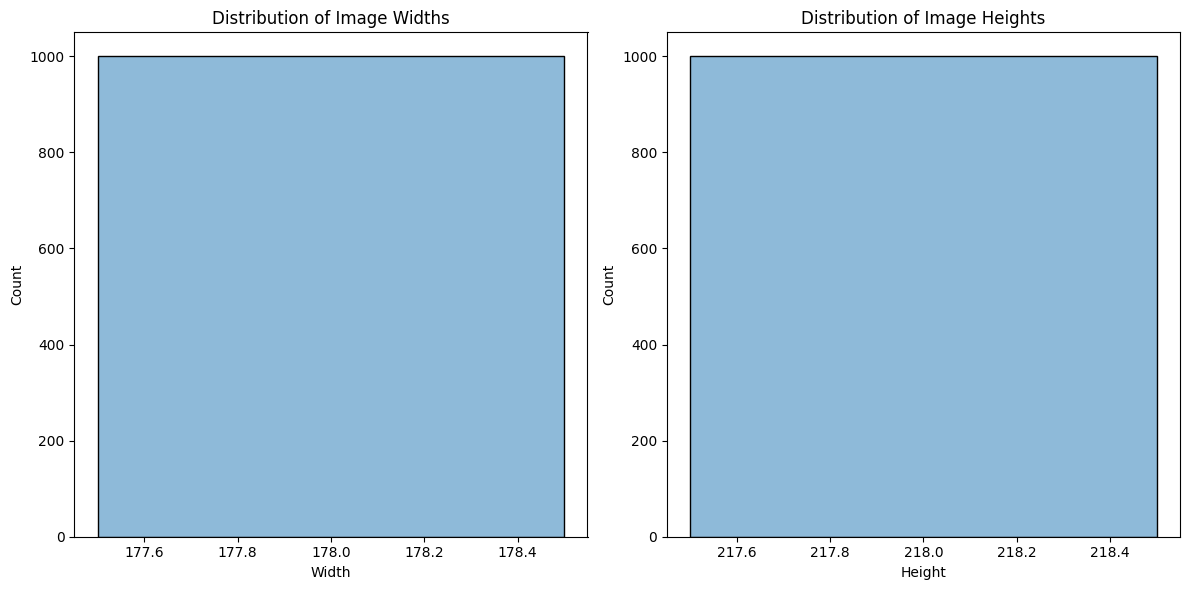

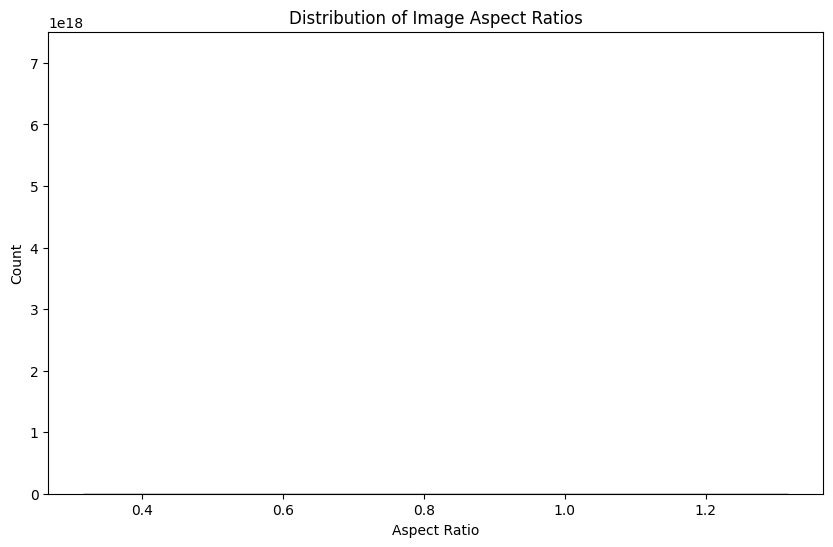

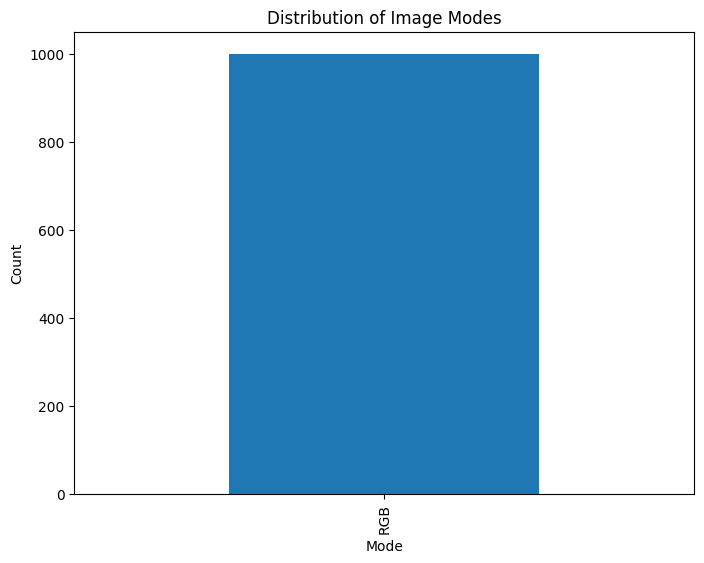

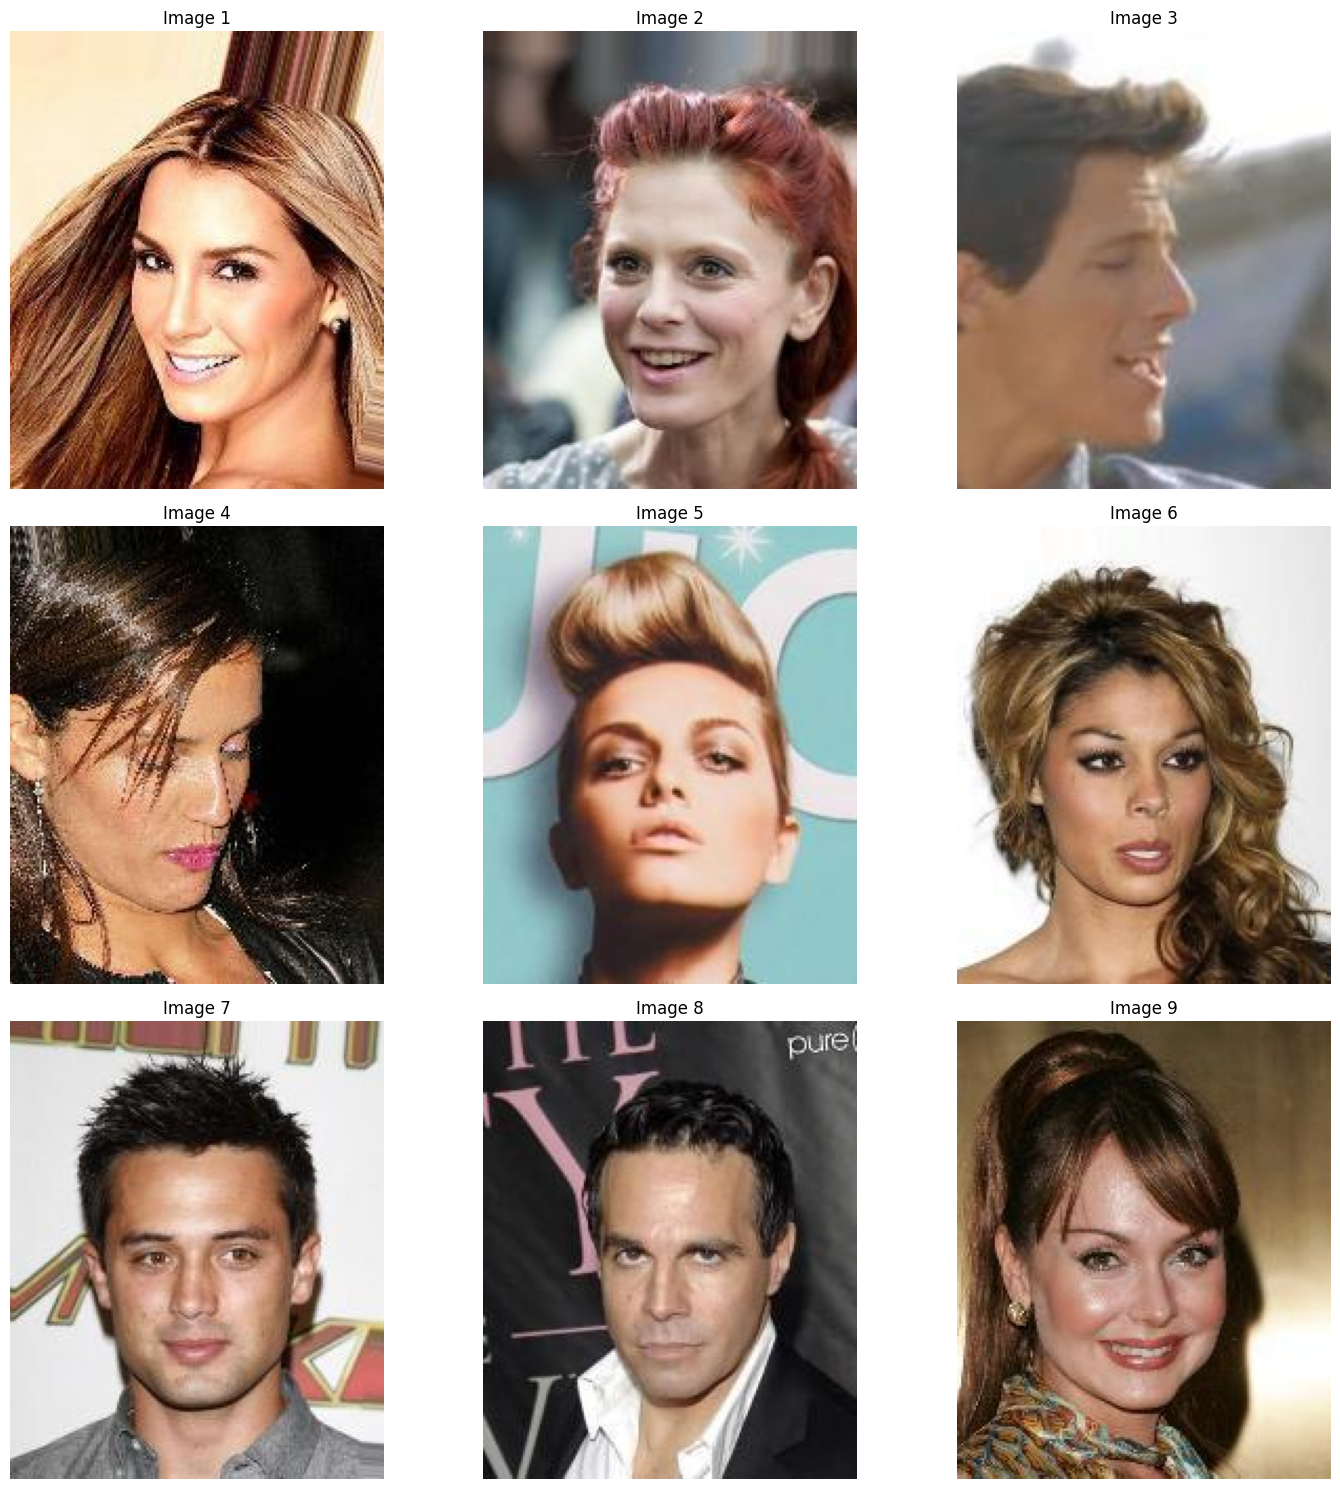

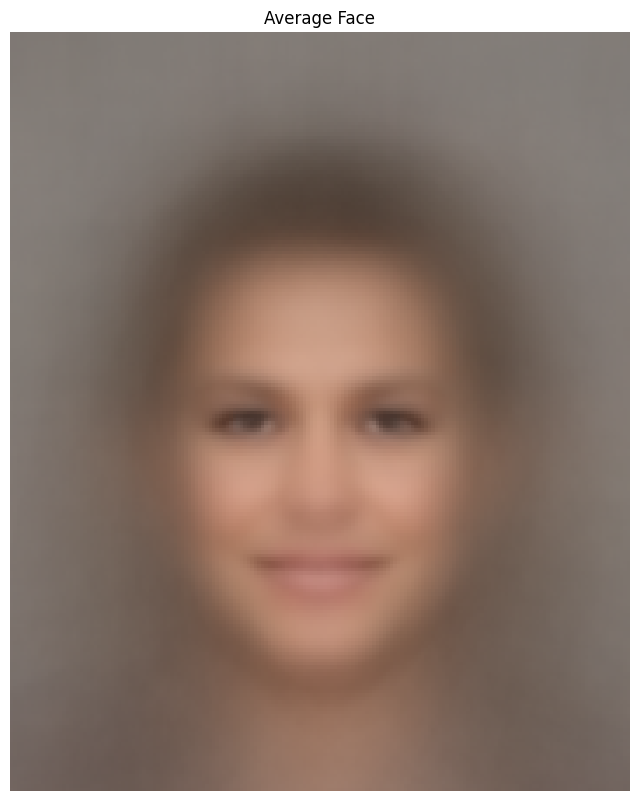

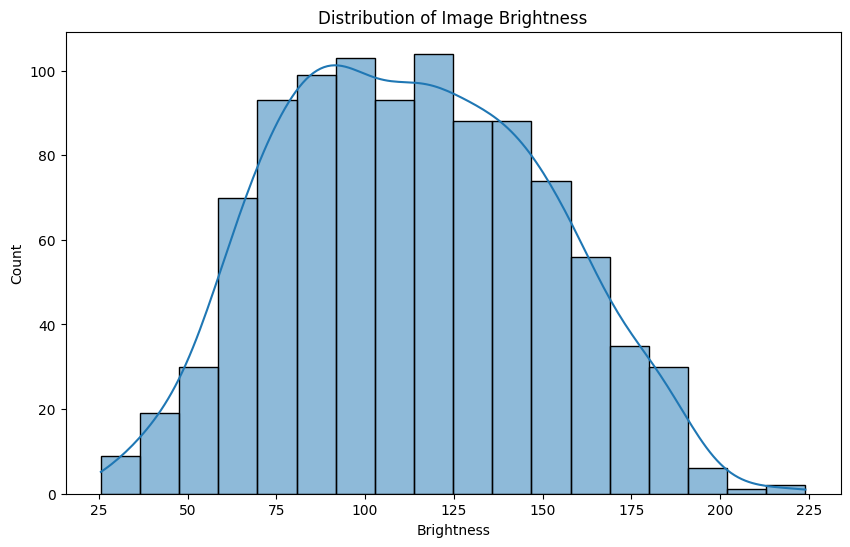

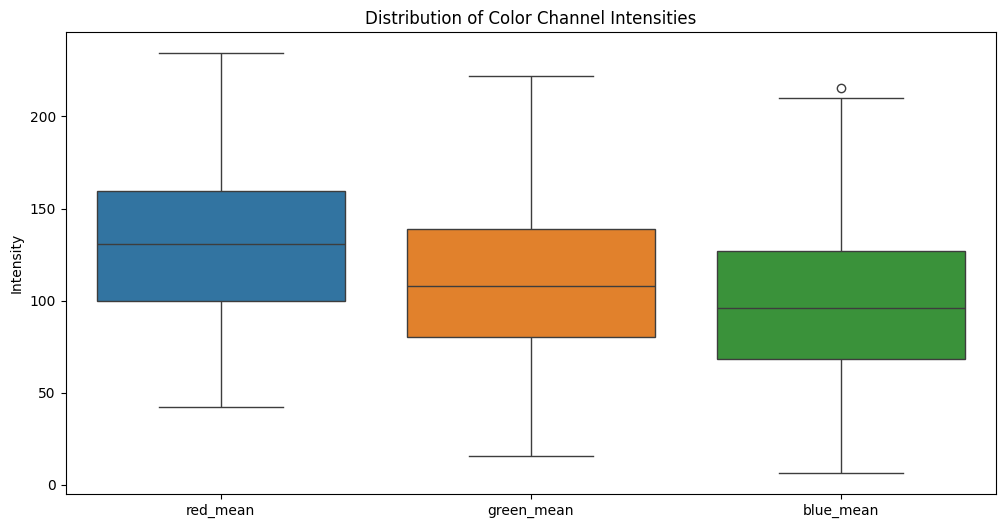

EDA complete. Please review the generated visualizations and statistics.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import pandas as pd
import numpy as np
from PIL import Image
import io

# Load the dataset (assuming it's already loaded as 'ds')

# Function to extract image properties
def get_image_properties(image):
    return {
        'width': image.width,
        'height': image.height,
        'aspect_ratio': image.width / image.height,
        'mode': image.mode
    }

# Extract properties for a subset of images
num_samples = 1000
image_properties = [get_image_properties(item['image']) for item in ds['train'].select(range(num_samples))]
df_properties = pd.DataFrame(image_properties)

# 1. Basic statistics of image properties
print("Basic statistics of image properties:")
print(df_properties.describe())

# 2. Distribution of image dimensions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_properties['width'], kde=True)
plt.title('Distribution of Image Widths')
plt.xlabel('Width')

plt.subplot(1, 2, 2)
sns.histplot(df_properties['height'], kde=True)
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.tight_layout()
plt.show()

# 3. Distribution of aspect ratios
plt.figure(figsize=(10, 6))
sns.histplot(df_properties['aspect_ratio'], kde=True)
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.show()

# 4. Image modes
mode_counts = df_properties['mode'].value_counts()
plt.figure(figsize=(8, 6))
mode_counts.plot(kind='bar')
plt.title('Distribution of Image Modes')
plt.xlabel('Mode')
plt.ylabel('Count')
plt.show()

# 5. Sample images visualization
def plot_sample_images(dataset, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        image = dataset['train'][i]['image']
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Image {i+1}")
    plt.tight_layout()
    plt.show()

plot_sample_images(ds)

# 6. Average image
def compute_average_image(dataset, num_samples=1000):
    sample_images = dataset['train'].select(range(num_samples))
    avg_image = np.zeros((218, 178, 3), dtype=np.float32)

    for item in sample_images:
        img_array = np.array(item['image'], dtype=np.float32)
        avg_image += img_array

    avg_image /= num_samples
    return avg_image.astype(np.uint8)

avg_image = compute_average_image(ds)
plt.figure(figsize=(8, 10))
plt.imshow(avg_image)
plt.title('Average Face')
plt.axis('off')
plt.show()

# 7. Image brightness distribution
def compute_brightness(image):
    return np.mean(image)

brightness_values = [compute_brightness(item['image']) for item in ds['train'].select(range(num_samples))]

plt.figure(figsize=(10, 6))
sns.histplot(brightness_values, kde=True)
plt.title('Distribution of Image Brightness')
plt.xlabel('Brightness')
plt.show()

# 8. Color channel analysis
def analyze_color_channels(image):
    r, g, b = image.split()
    return {
        'red_mean': np.mean(r),
        'green_mean': np.mean(g),
        'blue_mean': np.mean(b)
    }

color_data = [analyze_color_channels(item['image']) for item in ds['train'].select(range(num_samples))]
df_colors = pd.DataFrame(color_data)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_colors)
plt.title('Distribution of Color Channel Intensities')
plt.ylabel('Intensity')
plt.show()

print("EDA complete. Please review the generated visualizations and statistics.")

- **Memory usage:** You're loading 1000 images into memory at once, which could cause crashes on machines with limited RAM. Consider reducing num_samples if you're experiencing memory issues.
-**Image dimensions**: In the compute_average_image function, you're assuming all images are 218x178 pixels. Make sure this is correct for your dataset, or adjust the dimensions accordingly.
- **Error handling:** Add try-except blocks around image processing operations to handle potential errors gracefully.
- **Performance**: Some operations, like computing the average image and analyzing color channels, could be optimized for better performance.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


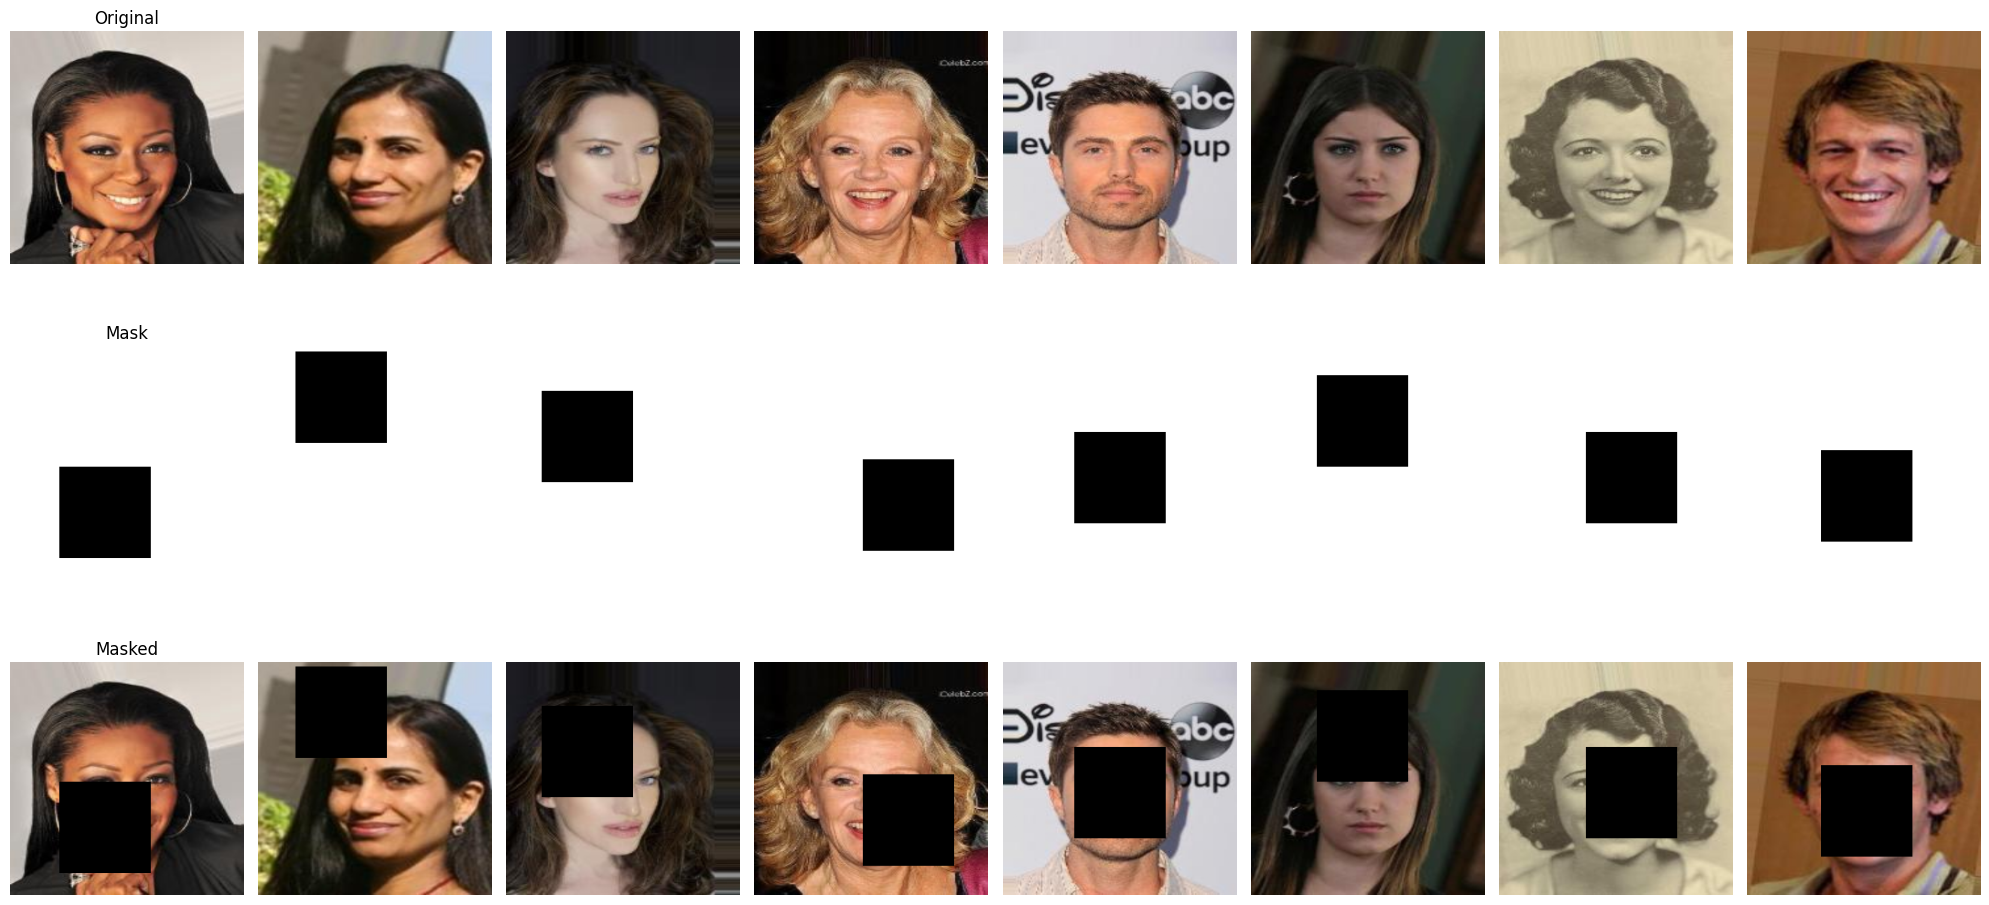

Dataset split and preprocessing pipeline created.
Total dataset size: 202599
Training set size: 162079
Validation set size: 20259
Test set size: 20261
Batch size: 32
Steps per epoch: 5065


In [6]:
import torch
import torchvision.transforms as transforms
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the CelebA-HQ dataset
ds = load_dataset("saitsharipov/CelebA-HQ")

class CelebAHQDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image']

        if self.transform:
            image = self.transform(image)

        return image

# Define image size
IMG_SIZE = 256

# Define preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Create the full dataset
full_dataset = CelebAHQDataset(ds['train'], transform=preprocess)

# Set random seed for reproducibility
torch.manual_seed(42)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

def create_mask(image, mask_size=100):
    """Create a random square mask for image inpainting"""
    _, h, w = image.shape
    top = np.random.randint(0, h - mask_size)
    left = np.random.randint(0, w - mask_size)
    mask = torch.ones_like(image)
    mask[:, top:top+mask_size, left:left+mask_size] = 0
    return mask

def apply_mask(image, mask):
    """Apply the mask to the image"""
    return image * mask

# Function to visualize a batch of preprocessed images with masks
def visualize_batch(dataloader, num_images=8):
    # Get a batch of images
    images = next(iter(dataloader))
    images = images[:num_images]  # Select only the first num_images

    # Create masks and apply them
    masks = [create_mask(img) for img in images]
    masked_images = [apply_mask(img, mask) for img, mask in zip(images, masks)]

    # Create a figure with three rows: original images, masks, and masked images
    fig, axes = plt.subplots(3, num_images, figsize=(20, 10))

    for i in range(num_images):
        # Original image
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')

        # Mask
        axes[1, i].imshow(masks[i].permute(1, 2, 0), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Mask')

        # Masked image
        axes[2, i].imshow(masked_images[i].permute(1, 2, 0))
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('Masked')

    plt.tight_layout()
    plt.show()

# Visualize a batch of preprocessed images with masks from the training set
visualize_batch(train_loader)

print("Dataset split and preprocessing pipeline created.")
print(f"Total dataset size: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(train_loader)}")